Creates temperature statistics based on the Prometheus data of the camera.
The last line of code can be used to export the graph to a PNG.

## How to get the graph

The following script polls the Prometheus data every second, reformats and writes them to STDOUT.
```
#!/bin/bash

host=192.168.1.1

while [ true ]; do
   content=$(curl -s http://$host:9090/metrics)
   exitCode=$?

   if [ $exitCode -ne 0 ]; then
      echo "ERROR: curl returned exit code $exitCode"
      exit $exitCode
   fi

   timestamp=$(date --iso-8601=ns)

   echo -n "$timestamp;"
   echo "$content" \
      | grep --invert-match -E '^\s*#' \
      | tr '\n' ';' \
      | sed -E 's/;+/;/' \
      | sed -E 's/octowatch_//g' \
      | sed -E 's/type=//g' \
      | sed -E 's/\{"/./g' \
      | sed -E 's/"\}\s+/=/g' \
      | sed -E 's/humidity\s*/humidity=/' \
      | sed -E 's/\s*;+/;/g'
   echo

   sleep 1
done

```

The output of the script looks like ...

```
2024-04-20T16:47:02,278108173+02:00;temperature.gpu=35.9;temperature.cpu=36.476;temperature.env=21.5;humidity=47.4;
2024-04-20T16:47:03,338418895+02:00;temperature.gpu=35.9;temperature.cpu=36.476;temperature.env=21.5;humidity=47.4;
2024-04-20T16:47:04,372415844+02:00;temperature.gpu=35.9;temperature.cpu=36.476;temperature.env=21.5;humidity=47.4;
2024-04-20T16:47:05,413095140+02:00;temperature.gpu=37.6;temperature.cpu=36.476;temperature.env=21.5;humidity=47.4;
2024-04-20T16:47:06,472427245+02:00;temperature.gpu=37.6;temperature.cpu=36.476;temperature.env=21.5;humidity=47.4;
```

You can use output redirection or the command "tee" to write the data to a file. Upload the file and correct the filename in the variable inputFile if necessary.


In [1]:
inputFile            = '20240520_2.csv'
timestampToStartFrom = '2024-05-20T08:55:00+02:00' # set it to empty string to start with first record

import dateutil.parser as dateParser
import matplotlib.pyplot as plt
import requests

response = requests.get('https://raw.githubusercontent.com/tederer/octowatch-evaluation/main/measurements/temperature/' + inputFile)
with open(inputFile, 'wb') as fd:
    for chunk in response.iter_content(chunk_size=128):
        fd.write(chunk)

start:          -0.0
close housing:  0.117
H.264:          0.717
MPJPEG:         1.717
IR:             2.717


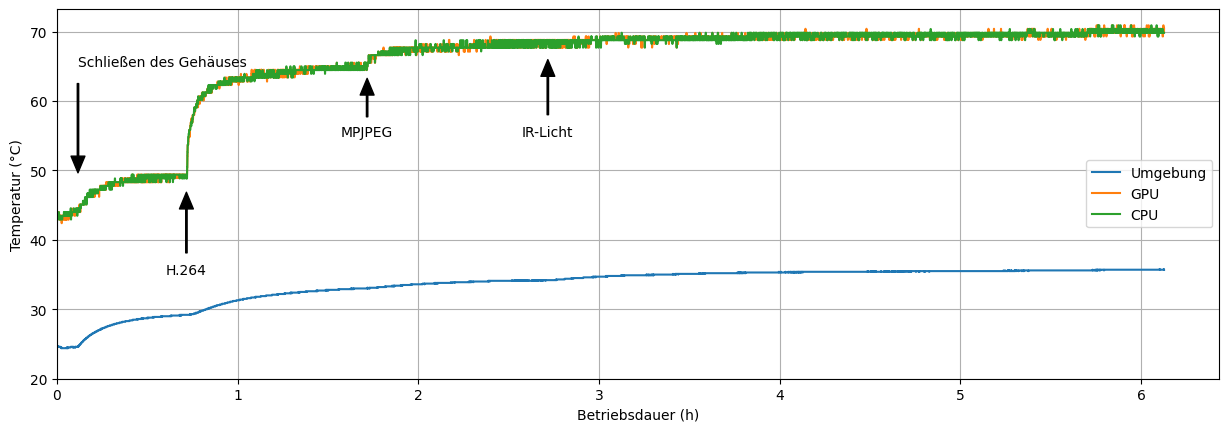

In [2]:
def getDuration(isoTimestamp, firstTimestampInSec):
  return (dateParser.parse(isoTimestamp).timestamp() - firstTimestampInSec) / 3600;

csvFile        = open(inputFile, 'r')
Lines          = csvFile.readlines()
startTimestamp = 0

if len(timestampToStartFrom) > 0:
  startTimestamp = dateParser.parse(timestampToStartFrom).timestamp()

durationSinceStartInHours = []
gpuTemperature            = []
cpuTemperature            = []
environmentTemperature    = []

firstLine = True
firstTimestampInSec = 0

for line in Lines:
  columns         = line.split(';')
  parsedTimestamp = dateParser.parse(columns[0])
  timestampInSec  = parsedTimestamp.timestamp()

  if startTimestamp > timestampInSec:
    continue

  if (firstLine):
    firstTimestampInSec = timestampInSec
    firstLine           = False

  durationSinceStartInHours.append((timestampInSec - firstTimestampInSec) / 3600)
  gpuTemperature.append(float(columns[1].split('=')[1]))
  cpuTemperature.append(float(columns[2].split('=')[1]))
  environmentTemperature.append(float(columns[3].split('=')[1]))

closeHousing  = getDuration('2024-05-20T09:02:00+02:00', firstTimestampInSec)
h264On        = getDuration('2024-05-20T09:38:00+02:00', firstTimestampInSec)
MpjpegOn      = getDuration('2024-05-20T10:38:00+02:00', firstTimestampInSec)
infraredOn    = getDuration('2024-05-20T11:38:00+02:00', firstTimestampInSec)
startDuration = (startTimestamp - firstTimestampInSec) / 3600

print('start:         ', round(startDuration, 3))
print('close housing: ', round(closeHousing, 3))
print('H.264:         ', round(h264On, 3))
print('MPJPEG:        ', round(MpjpegOn, 3))
print('IR:            ', round(infraredOn, 3))

figure, axes = plt.subplots(figsize=[15, 4.8])
axes.plot(durationSinceStartInHours, environmentTemperature, label='Umgebung')
axes.plot(durationSinceStartInHours, gpuTemperature, label='GPU')
axes.plot(durationSinceStartInHours, cpuTemperature, label='CPU')

axes.set_xlabel('Betriebsdauer (h)')
axes.set_ylabel('Temperatur (°C)')
axes.set_xlim(0)
axes.set_ylim(20)
axes.legend(loc='center right')
axes.grid(True)
arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=10)
axes.annotate('Schließen des Gehäuses', xy=(closeHousing, 48), xytext=(closeHousing, 65), horizontalalignment='left', arrowprops=arrowprops)
axes.annotate('H.264',                  xy=(h264On, 48),       xytext=(h264On, 35),       horizontalalignment='center', arrowprops=arrowprops)
axes.annotate('MPJPEG',                 xy=(MpjpegOn, 64),     xytext=(MpjpegOn, 55),     horizontalalignment='center', arrowprops=arrowprops)
axes.annotate('IR-Licht',               xy=(infraredOn, 67),   xytext=(infraredOn, 55),   horizontalalignment='center', arrowprops=arrowprops)

figure.savefig('graph.png', dpi=300)